# Neural Style Transfer
##### Author: Prasanna Rahavendra A
##### github: [Prasanna2000](https://github.com/Prasanna2000)

##### Run it on Google Colab:
[Run it on Google Colab](https://colab.research.google.com/github/Prasanna2000/NeuralStyleTransfer/blob/master/Neural_Style_Transfer.ipynb)

### In this project we'll use transfer learning for the task of neural style transfer.
### We will make use a pre-trained VGG19 model, trained on the ImageNet dataset for this task.
#### The VGG network architecture was introduced by Simonyan and Zisserman in their 2014 paper, Very Deep Convolutional Networks for Large Scale Image Recognition. Information on the VGG model architecture can be found [here](https://arxiv.org/abs/1409.1556).

## Importing necessary modules

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19

### Loading the VGG 19 Module that we'll use for this project

In [2]:
model = VGG19(include_top=False,weights="imagenet")
model.trainable = False

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Helper Functions to Preprocess, Deprocess Display and Save the Image

In [4]:
def load_and_process_image(img):
    img = load_img(img)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img,axis = 0)
    
    return img

#### We deprocess the image in a certain way in which it was preprocessed for the input of the model (VGG 19)

In [5]:
def deprocess(array):
    '''Does the opposite of preprocess_input method of vgg19'''
    array[:,:,0] += 103.939
    array[:,:,1] += 116.779
    array[:,:,2] += 123.68
    
    array = array[:,:,::-1]
    
    array = np.clip(array,0,255).astype(np.uint8)
    
    return array

In [6]:
def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image,axis = 0)
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    
    return

In [7]:
def save_image(image, display=False):
    if len(image.shape) == 4:
        img = np.squeeze(image,axis = 0)
    img = deprocess(img)
    
    if display:
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
    plt.imsave("generated.jpg",img)
    
    return

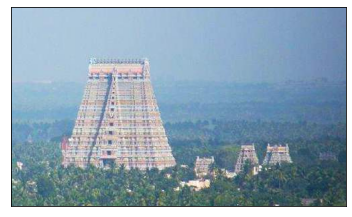

In [8]:
display_image(load_and_process_image("content.jpg"))

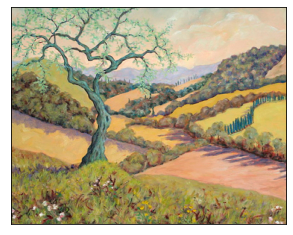

In [9]:
display_image(load_and_process_image("style.jpg"))

## Content and Style Models

In [10]:
content_layer = "block5_conv2"
style_layers = ["block1_conv1","block3_conv1","block5_conv1"]

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input,
                     outputs = model.get_layer(layer).output) for layer in style_layers]

## Content Cost

In [11]:
def content_cost(content,generated):
    activations_of_content_img = content_model(content)
    activations_of_generated_img = content_model(generated)
    
    cost = tf.reduce_mean(tf.square(activations_of_content_img - activations_of_generated_img))
    
    return cost

## Gram Matrix

#### Gram Matrices are used to calculate the style cost.

In [12]:
def gram_matrix(array):
    num_channels = int(array.shape[-1])
    reshaped_array = tf.reshape(array,[-1,num_channels])
    num_elements = tf.shape(reshaped_array)[0]
    
    gram_matrix = tf.matmul(reshaped_array, reshaped_array, transpose_a = True)
    scaled_gram_matrix = gram_matrix/tf.cast(num_elements,tf.float32)
    
    return scaled_gram_matrix

## Style Cost

In [13]:
def style_cost(style, generated):
    weight = 1/len(style_models)
    total_style_cost = 0
    
    for model in style_models:
        activations_of_style_img = model(style)
        activations_of_generated_img = model(generated)
        
        style_img_gram_matrix = gram_matrix(activations_of_style_img)
        generated_img_gram_matrix = gram_matrix(activations_of_generated_img)
        
        current_cost = tf.reduce_mean(tf.square(style_img_gram_matrix - generated_img_gram_matrix))
        total_style_cost += current_cost * weight
        
    return total_style_cost
        

## Training Loop

In [14]:
import time
generated_images = []

def training(content_path, style_path, epochs = 20, alpha = 10., beta = 20.):
    content_img = load_and_process_image(content_path)
    style_img = load_and_process_image(style_path)
    
    generated_image = tf.Variable(content_img, dtype = tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 7.0)
    
    best_cost = 1e12 + 0.1 #some high value
    best_img = None
    
    start_time = time.time()
    
    print(f"Starting Training...")
    
    for i in range(epochs):
        with tf.GradientTape() as tape:
            cont_cost = content_cost(content_img,generated_image)
            styl_cost = style_cost(style_img,generated_image)
            
            total_cost = alpha * cont_cost + beta * styl_cost
            
            grads = tape.gradient(total_cost, generated_image)
            optimizer.apply_gradients([(grads,generated_image)])
            
            if total_cost < best_cost:
                best_cost = total_cost
                best_img = generated_image.numpy()
            
            print(f"Epoch({i+1}) Cost: {total_cost}. Time elapsed: {round((time.time() - start_time),2)} seconds")
            
            generated_images.append(generated_image.numpy())
            
    return best_img

In [15]:
generated_images = []
best_image = training("content.jpg","style.jpg")

Starting Training...
Epoch(1) Cost: 1357093376.0. Time elapsed: 14.39 seconds
Epoch(2) Cost: 689130240.0. Time elapsed: 17.87 seconds
Epoch(3) Cost: 666907456.0. Time elapsed: 21.32 seconds
Epoch(4) Cost: 417204096.0. Time elapsed: 24.7 seconds
Epoch(5) Cost: 317673760.0. Time elapsed: 28.13 seconds
Epoch(6) Cost: 264513568.0. Time elapsed: 32.41 seconds
Epoch(7) Cost: 225196000.0. Time elapsed: 36.19 seconds
Epoch(8) Cost: 206634000.0. Time elapsed: 39.87 seconds
Epoch(9) Cost: 179360192.0. Time elapsed: 44.55 seconds
Epoch(10) Cost: 149578656.0. Time elapsed: 50.33 seconds
Epoch(11) Cost: 129984824.0. Time elapsed: 54.39 seconds
Epoch(12) Cost: 113503680.0. Time elapsed: 59.23 seconds
Epoch(13) Cost: 99946304.0. Time elapsed: 63.98 seconds
Epoch(14) Cost: 91186920.0. Time elapsed: 69.37 seconds
Epoch(15) Cost: 82576528.0. Time elapsed: 77.6 seconds
Epoch(16) Cost: 73159704.0. Time elapsed: 88.71 seconds
Epoch(17) Cost: 65866952.0. Time elapsed: 95.23 seconds
Epoch(18) Cost: 60164844.

## Saving and Displaying the best image (i.e. the one that had the least loss)

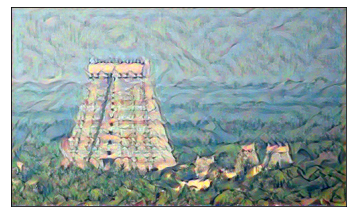

In [16]:
save_image(best_image, display=True)

## Viewing the generated images at each step of the training

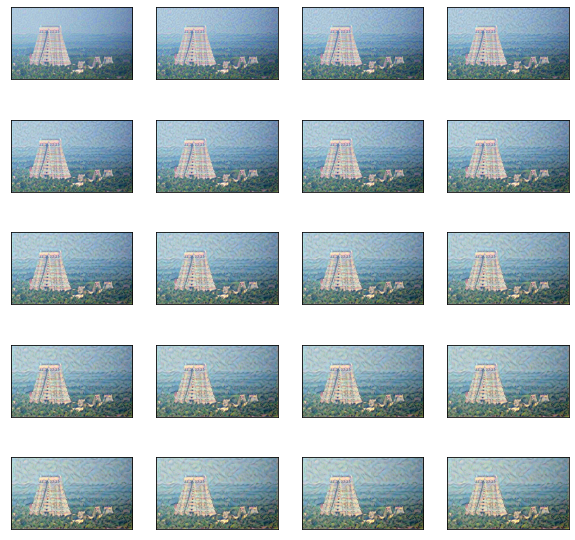

In [17]:
plt.figure(figsize=(10,10))

for i in range(20):
    plt.subplot(5, 4, i+1)
    display_image(generated_images[i])
    
plt.show()